# Visão Computacional

## Classificação de Imagens
## Prática de Classificação de Imagens

- Importando os pacotes necessários
- Carregando as imagens de faces
- Construindo os conjuntos de treinamento e teste
- Treinando e ajustando parâmetros do SVM
- Avaliando os resultados

Observações: 
- Ativar a GPU (Menu [Runtime], opção [Change runtime type])
- Sem GPU, a execução deste caderno pode levar mais de 40 minutos.


# Importando os pacotes

In [11]:
!pip install sklearn
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# use seaborn plotting defaults
import seaborn as sns; sns.set()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Classificação de imagens (Reconhecimento Facial)

O problema de reconhecimento facial pode ser visto como um problema de classificação de imagens quando (i) a imagem representa uma face (rosto) e (ii) há um rótulo (classe) associado a ela.

Usaremos o conjunto de dados *Labeled Faces in the Wild*, composto por milhares de imagens faciais de várias figuras públicas. Esses dados estão disponíveis no scikit-learn.

##Carregando as imagens de faces

In [12]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=60)
print('Número de faces (classes) = ',faces.target_names.size)
print("Faces = ",faces.target_names)
print('Dimensões = ',faces.images.shape)

Número de faces (classes) =  8
Faces =  ['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Junichiro Koizumi' 'Tony Blair']
Dimensões =  (1348, 62, 47)


Podemos visualizar algumas as imagens (faces) que estamos trabalhando:

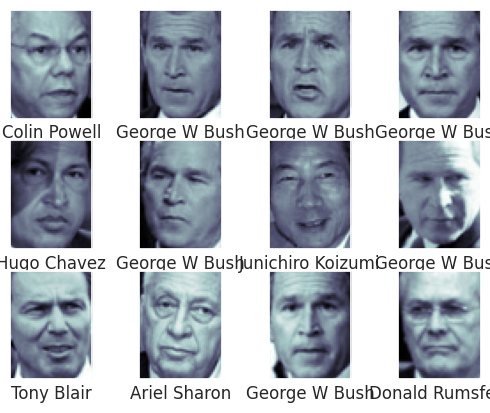

In [13]:
fig, ax = plt.subplots(3, 4)
for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[i], cmap='bone')
    axi.set(xticks=[], yticks=[],
            xlabel=faces.target_names[faces.target[i]])

##Construindo os conjuntos de treinamento e teste

Cada imagem contém `[62×47]`, ou seja, aproximadamente `3,000` pixels.

###PCA
Poderíamos simplesmente utilizar cada pixel como um atributo (*feature*), mas geralmente é mais eficaz extrairmos as características mais significativas.

Nesta aula, utilizaremos Análise de Componentes Principais (PCA, do inglês *Principal Component Analysis*). Lembramos que PCA é uma das formas mais simplificadas para descrição / representação de imagens. Poderíamos utilizar  descritores de histogramas de cores, como o CGH (*Global Color Histogram*), utilizado na Videoaula 17.

Neste ponto, o importante é observar que vamos trabalhar com um número bastante reduzido de atributos (*features*) para cada imagem. No caso desta aplicação, vamos extrair as `150` componentes principais (*n_components=150*) para alimentar nosso classificador.

###SVM

As máquinas de vetores de suporte (SVMs, do inglês *Support Vector Machines*) compõem uma poderosa classe de algoritmos para aprendizado supervisionado, tanto para classificação como para regressão. 

Uma das principais vantagens do SVM é seu bom desempenho em problemas de alta dimensionalidade. Por essa razão, vamos utilizá-lo nesta aula.

In [14]:
from sklearn.svm import SVC
from sklearn.decomposition import PCA as RandomizedPCA
from sklearn.pipeline import make_pipeline

pca = RandomizedPCA(n_components=150, whiten=True, random_state=42)
svc = SVC(kernel='rbf', class_weight='balanced')
model = make_pipeline(pca, svc)

# Para avaliar a capacidade de predição do nosso classificador SVM, 
# dividiremos o conjunto de dados em treino e teste
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(faces.data, faces.target,
                                                random_state=42)

##Treinando e ajustando parâmetros do SVM
Finalmente, podemos usar uma busca em Grid para encontrar os melhores parâmetros do classificador. Nesse caso, realizaremos uma validação cruzada (sobre o conjunto de treino) para ajustar os valores de ``C`` (que controla a rigidez da margem) e ``gamma`` (que controla o tamanho do *kernel* da função de base radial) e, assim, encontrar o melhor modelo:


In [15]:
from sklearn.model_selection import GridSearchCV
param_grid = {'svc__C': [1, 3, 5, 10, 35, 50],
              'svc__gamma': [0.0001, 0.0003, 0.0005, 0.001, 0.0035, 0.005]}
grid = GridSearchCV(model, param_grid)

%time grid.fit(Xtrain, ytrain)
print(grid.best_params_)

CPU times: user 1min 52s, sys: 1min 19s, total: 3min 12s
Wall time: 2min 10s
{'svc__C': 3, 'svc__gamma': 0.0035}


Os melhores valores foram encontrados no meio da grid; se estivessem nos extremos, poderíamos expandir o grid para procurar valores melhores.

Agora, com o melhor modelo encontrado. podemos prever os rótulos das imagens do conjunto de teste, as quais o modelo ainda não teve acesso:

##Avaliando os resultados

In [16]:
model = grid.best_estimator_
yfit = model.predict(Xtest)

Podemos visualizar algumas dessas imagens e os valores previstos pelo modelo:

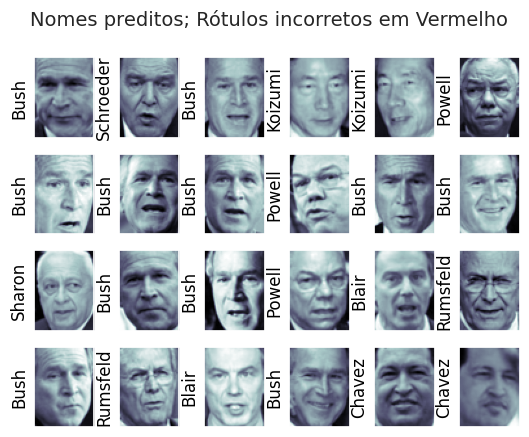

In [17]:
fig, ax = plt.subplots(4, 6)
for i, axi in enumerate(ax.flat):
    axi.imshow(Xtest[i].reshape(62, 47), cmap='bone')
    axi.set(xticks=[], yticks=[])
    axi.set_ylabel(faces.target_names[yfit[i]].split()[-1],
                   color='black' if yfit[i] == ytest[i] else 'red')
fig.suptitle('Nomes preditos; Rótulos incorretos em Vermelho', size=14);

Dessa pequena amostra, nosso modelo SVM classificou errado apenas uma única imagem (o rosto de Bush foi rotulado como Blair) 

Podemos ter uma ideia melhor do desempenho do nosso modelo se usarmos o relatório de classificação, que lista as principais estatísticas considerando cada classe:

In [18]:
from sklearn.metrics import classification_report
print(classification_report(ytest, yfit,
                            target_names=faces.target_names))

                   precision    recall  f1-score   support

     Ariel Sharon       0.87      0.87      0.87        15
     Colin Powell       0.86      0.90      0.88        68
  Donald Rumsfeld       0.80      0.77      0.79        31
    George W Bush       0.91      0.92      0.92       126
Gerhard Schroeder       0.90      0.83      0.86        23
      Hugo Chavez       1.00      0.75      0.86        20
Junichiro Koizumi       1.00      1.00      1.00        12
       Tony Blair       0.83      0.90      0.86        42

         accuracy                           0.88       337
        macro avg       0.90      0.87      0.88       337
     weighted avg       0.89      0.88      0.88       337



Também podemos visualizar a matriz de confusão:

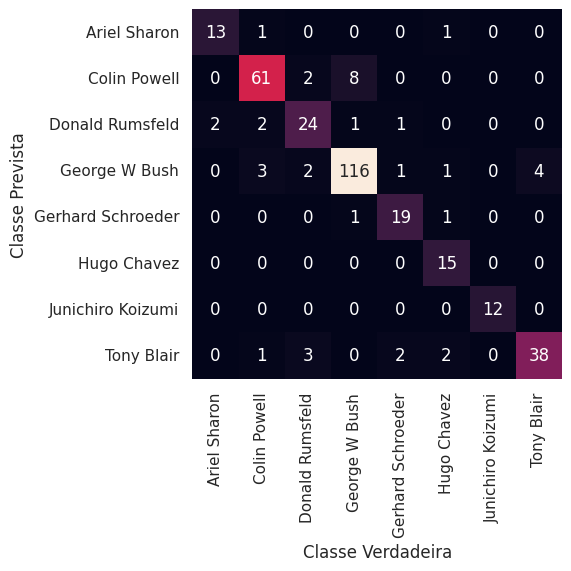

In [19]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(ytest, yfit)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=faces.target_names,
            yticklabels=faces.target_names)
plt.xlabel('Classe Verdadeira')
plt.ylabel('Classe Prevista');

Isso nos ajuda a ter uma ideia melhor de quais rótulos estão sendo mais difíceis para o classificador reconhecer.

Nas aplicações mais reais de reconhecimento facial, não temos disponíveis imagens contendo apenas um rosto específico (pré-cortado), como vimos agora, cujo objetivo é rotular uma imagem inteira. Nesses casos, utilizamos algoritmos mais sofisticados para detecção/reconhecimento de objetos (neste caso, faces), tópico que abordaremos na próxima semana.
